In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.metrics import *
#from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.neural_network import MLPClassifier

In [2]:
!pip install imblearn

### Data Cleaning Begins

    """
    Until where indicated, all code taken from

    Long, A. (2020, January 30).
        Using Machine Learning to Predict Hospital Readmission for Patients with
        Diabetes with Scikit-Learn. Retrieved November 21, 2020,
        from https://towardsdatascience.com/predicting-hospital-readmission-for-
        patients-with-diabetes-using-scikit-learn-a2e359b15f0
        
    Except for some comments, which I've added
    """
    """
    Until where indicated, all code taken from
    https://github.com/vignesh-bhat1999/predicting_hospital_readmissions
    Vignesh B Svignesh-bhat1999
    Machine learning and deep learning enthusiast
    All notes are preserved for better understanding of the Data Cleaning method
    """

In [3]:
def categorize_diagnosis(data,new,old):
    '''
    The diagnosis columns are converted from icd9 codes to one of the 9 categories.
    The function creates a new column which consists of one of the 10 categories of disease.
    Nan values are considered as a new category
    '''
    #copying old column into new column
    data[new] = data[old]
    #filling NaN values with -1 category
    data[new] = data[new].fillna(-1)
    #if the code contians V or E then it is considered as category 0.
    data.loc[data[new].str.contains('V',na=False), [new]] = 0
    data.loc[data[new].str.contains('E',na=False), [new]] = 0
    #converting string column to float.
    data[new] = data[new].astype(float)
    #iterating through all the rows of the dataframe
    for index, row in data.iterrows():
        #checking if the code of the row belong to category 1,
        if (row[new] >= 390 and row[new] < 460) or (np.floor(row[new]) == 785):
            #assigning category 1 to the new column of the row.
            data.loc[index, new] = 1
        #checking if the code of the row belong to category 2,
        elif (row[new] >= 460 and row[new] < 520) or (np.floor(row[new]) == 786):
            #assigning category 2 to the new column of the row.
            data.loc[index, new] = 2
        elif (row[new] >= 520 and row[new] < 580) or (np.floor(row['new_diag1']) == 787):
            data.loc[index, new] = 3
        elif (np.floor(row[new]) == 250):
            data.loc[index, new] = 4
        elif (row[new] >= 800 and row[new] < 1000):
            data.loc[index, new] = 5
        elif (row[new] >= 710 and row[new] < 740):
            data.loc[index, new] = 6
        elif (row[new] >= 580 and row[new] < 630) or (np.floor(row[new]) == 788):
            data.loc[index, new] = 7
        elif (row[new] >= 140 and row[new] < 240):
            data.loc[index, new] = 8
        elif row[new] > 0 :
            #if the code of the row does not belong to any category then it is given 0.
            data.loc[index, new] = 0

def data_prep(fileName):
    """
    Until where indicated, all code taken from
    https://github.com/vignesh-bhat1999/predicting_hospital_readmissions
    Vignesh B Svignesh-bhat1999
    Machine learning and deep learning enthusiast
    All notes are preserved for better understanding of the Data Cleaning method
    """
    import pandas as pd
    import numpy as np
    print("line359 time=",time.asctime( time.localtime(time.time()) ))
    data = pd.read_csv(fileName)
    data.head()
    
    '''Data preprocessing'''
    
    #data contains multiple inpatient visits for some patients, I considered only the first encounter for each patient as mentioned in the research paper to determine whether or not they were readmitted within 30days. So the duplicate values are removed.
    #creating new column duplicate which contains whether the row is duplicated or not. It is boolean.
    if fileName == 'C2T1_Train.csv':
        data['duplicate'] = data['patient_nbr2'].duplicated()
    else:
        data['duplicate'] = data['patient_nbr'].duplicated()
    #only those rows which are not duplicated are kept in the dataset.
    data = data[data['duplicate'] == False]
    #the duplicate column is dropped.
    data = data.drop(['duplicate'], axis = 1)
    #removing the patients who are dead or in hospice.
    data = data.loc[~data['discharge_disposition_id'].isin([11,13,14,19,20,21])]
    #resetting index of the dataframe
    data = data.reset_index()
    data = data.drop(['index'],axis=1)
    #replacing '?' with NaN
    data = data.replace('?',np.nan)
    #let us check how many percentage of data in each column is nan
    # print((data.isna().sum()/len(data))*100)
    #We can observe that weight has the heighest nan values at 96% of data with nan values. Medical speciality and payer code have 48% and 43% nan values respectively.
    #The race and diagnosis columns also have nan values but are less in number.
    #The weight column can be dropped since there is very high percentage of nan values. The payer code and medical specialty column missing values can be found using imputation techniques since more than 50% data is available in both cases.
    #removing weight,payer_code and medical_specialty columns
    data = data.drop(['weight'], axis = 1)
    
    '''Exploratory data analysis'''
    '''Univariate Analysis'''
    
    # Race
    # the race column consists of Caucasian,AfricanAmerican, Hispanic, Asian and other as categories. It consists of 2.7% NaN values
    #checking value counts
    # print(data['race'].value_counts())
    # plt.figure(figsize=(10,5))
    #plotting count plot with seaborn
    # sns.countplot(data['race']).set_title('Count of race');
    # plt.show()
    #filling nan values of race with mode
    data['race'].fillna(data['race'].mode()[0], inplace=True)
    
    # Gender
    # The gender column tells us whether the patient is male or female.
    # print(data['gender'].value_counts())
    #3 values are unknown. We can either fill these values or drop the rows. Dropping the rows would be better since the data is also considered as invalid/Unknown incase of gender.
    #dropping rows with gender as invalid.
    data = data[data.gender != 'Unknown/Invalid']
    # plt.figure(figsize=(10,5))
    # sns.countplot(data['gender']).set_title('Count of gender');
    # plt.show()
    # The female count is more than male count but the difference is small.
    # I have changed the label of male to 1 and female to 0.
    data['gender'] = data['gender'].replace('Male', 1)
    data['gender'] = data['gender'].replace('Female', 0)
    
    # Age
    # print(data['age'].value_counts())
    # plt.figure(figsize=(10,5))
    # sns.countplot(data['age']).set_title('Count of age');
    # plt.show()
    # As expected, the patients with age less than 40 years are less in number when compared to patients with age greater than 40 years.
    # The number of patients are highest in the age group of 70-80 years.
    # I will be grouping the age feature into 3 categories as mentioned in the research paper.
    #custom encoding age
    data.loc[data['age'] == '[0-10)', ['age']] = 0
    data.loc[data['age'] == '[10-20)', ['age']] = 0
    data.loc[data['age'] == '[20-30)', ['age']] = 0
    data.loc[data['age'] == '[30-40)', ['age']] = 1
    data.loc[data['age'] == '[40-50)', ['age']] = 1
    data.loc[data['age'] == '[50-60)', ['age']] = 1
    data.loc[data['age'] == '[60-70)', ['age']] = 2
    data.loc[data['age'] == '[70-80)', ['age']] = 2
    data.loc[data['age'] == '[80-90)', ['age']] = 2
    data.loc[data['age'] == '[90-100)', ['age']] = 2
    # plt.figure(figsize=(10,5))
    # sns.countplot(data['age']).set_title('Count of age');
    # plt.show()
    
    # Admission_type_id
    # Obtained from mappings given in uiuc:
    # print(data['admission_type_id'].value_counts())
    # plt.figure(figsize=(10,5))
    # sns.countplot(data['admission_type_id']).set_title('Count of admission type');
    # In Admission_type_id most of the patients are admitted with id emergency, followed by Elective. *Some of the patients admission type id is not available. Null and Not mapped categories are also present.
    
    ### Discharge_disposition_id
    # print(data['discharge_disposition_id'].value_counts())
    # plt.figure(figsize=(15,5))
    # sns.countplot(data['discharge_disposition_id']).set_title('Count of discharge disposition id');
    #grouping patients who are transfered to another hospital
    data.loc[(data['discharge_disposition_id'] == 3) | (data['discharge_disposition_id'] == 4)|
             (data['discharge_disposition_id'] == 5) | (data['discharge_disposition_id'] == 16)|
             (data['discharge_disposition_id'] == 22) |(data['discharge_disposition_id'] == 23)|
             (data['discharge_disposition_id'] == 24)|(data['discharge_disposition_id'] == 10),
             ['discharge_disposition_id']] = 2 
    #grouping patients who are dischareed to home under some conditions
    data.loc[(data['discharge_disposition_id'] == 6) | (data['discharge_disposition_id'] == 8)
             ,['discharge_disposition_id']] = 1
    #grouping patients who are transfered in the same hospital
    data.loc[(data['discharge_disposition_id'] == 15) | (data['discharge_disposition_id'] == 17)|
             (data['discharge_disposition_id'] == 9),['discharge_disposition_id']] = 3
    #grouping patients who are invalid, null or unknown
    data.loc[(data['discharge_disposition_id'] == 25) | (data['discharge_disposition_id'] == 26)|
             (data['discharge_disposition_id'] == 18),['discharge_disposition_id']] = 4
    # plt.figure(figsize=(15,5))
    # sns.countplot(data['discharge_disposition_id']).set_title('Count of discharge disposition id');
    # * The discharge_disposition_id column is divided into 21 different categories which was then changed to 8 categories after careful observations
    # * We can observe that most of the patients are discharged to home.
    # * The patients who have passed away or in hospice are not present since we have already removed those rows from the data.
    
    
    ### admission_source_id
    # print(data['admission_source_id'].value_counts())
    # plt.figure(figsize=(15,5))
    # sns.countplot(data['admission_source_id']).set_title('Count of admission source id');
    #grouping patients who are referred
    data.loc[(data['admission_source_id'] == 2) | (data['admission_source_id'] == 3),
             ['admission_source_id']] = 1 
    #grouping patients who are transfered.
    data.loc[(data['admission_source_id'] == 5) | (data['admission_source_id'] == 6)|
             (data['admission_source_id'] == 10) | (data['admission_source_id'] == 22)|
             (data['admission_source_id'] == 25),['admission_source_id']] = 4 
    #grouping patients who are null/invalid or not mapped.
    data.loc[(data['admission_source_id'] == 15) | (data['admission_source_id'] == 17)|
             (data['admission_source_id'] == 20) | (data['admission_source_id'] == 21),
             ['admission_source_id']] = 9
    # plt.figure(figsize=(15,5))
    # sns.countplot(data['admission_source_id']).set_title('Count of admission source id');
    # admission_source_id mappings are given in the ids_mappings.csv present in UCI.
    # The categories were changed from 17 to 8.
    # We can observe that most of the patients admission source is emergency room, followed by referals.
    
    
    # Time_in_hospital
    # print(data['time_in_hospital'].value_counts())
    # print(data['time_in_hospital'].describe())
    # plt.figure(figsize=(15,5))
    # sns.countplot(data['time_in_hospital']).set_title('Count of time in hospital');
    # The time in hospital column categorizes the patients stay ranging from 1 day to 14 days.
    # The patients on average stay 4 days and most patients stay 3-4 days.
    # The patients rarely stay more than 12 days.
    # We can observe a positive skew in the plot.
    
    ### num_lab_procedures
    # Refers to number of lab tests performed during the encounter
    # print(data['num_lab_procedures'].describe())
    # plt.figure(figsize=(15,5))
    # sns.distplot(data['num_lab_procedures']).set_title('number of lab procedures');
    # We can observe that on average 43 lab procedures are done during a patient encounter.
    # A spike is also found near 0-2 procedures which suggest less number of lab tests were done on some patients.
    
    
    ### Num_procedures
    # Refers to number of procedures (other than lab tests) performed during the encounter
    # print(data['num_procedures'].value_counts())
    # plt.figure(figsize=(15,5))
    # sns.countplot(data['num_procedures']).set_title('number of other procedures');
    # It is a categorical feature.
    # Most of the patients do not perform tests other than lab tests.
    
    ### Num_medications
    # Refers to number of distinct generic names administered during the encounter
    # print(data['num_medications'].describe())
    # plt.figure(figsize=(15,5))
    # sns.distplot(data['num_medications']).set_title('number of medications');
    # data[data['num_medications']>70]
    # Most of the patients are provided 16 medications on average.
    # Only 7 patients are given more than 70 medications.
    # The plot has positive skewness and resembles normal distribution to a cetain extent
    
    
    # Number_outpatient
    # Refers to number of outpatient visits of the patient in the year preceding the encounter
    # print(data['number_outpatient'].describe())
    # print(data['number_outpatient'].value_counts())
    # plt.figure(figsize=(15,5))
    # sns.distplot(data['number_outpatient']).set_title('number of outpatient visits');
    # We can observe that most of the patients do not have any outpatient visits.
    # Very less patients have more than 15 outpatient visits
    
    
    # Number_emergency
    # Refers to number of emergency visits of the patient in the year preceding the encounter
    # print(data['number_emergency'].describe())
    # plt.figure(figsize=(15,5))
    # sns.distplot(data['number_emergency']).set_title('number of emergency visits');
    # It is similar to number_outpatient distplot.
    # We can observe that most of the patients do not have any emergency visits.
    
    # Number_inpatient
    # Refers to number of inpatient visits of the patient in the year preceding the encounter
    # print(data['number_inpatient'].describe())
    # plt.figure(figsize=(15,5))
    # sns.countplot(data['number_inpatient']).set_title('number of inpatient visits');
    # We can observe that most of the patients do not have any inpatient visits.
    # It is similar to other visit figures seen.
    # We can create a new feature 'visits' which will be some of inpatient, outpatient and emergency visits since all three are distributed in similar ways.
    
    
    # Diagnosis
    # All three columns contain code which are categorized into one of the 9 groups given below.
    # We can categorize these codes into the 9 categories given above and use them as diagnosis of diseases which come under these 9 categories. This idea has been taken from the research paper.
    #https://www.kaggle.com/iabhishekofficial/prediction-on-hospital-readmission.
    # def categorize_diagnosis(data,new,old):
    #     '''
    #     The diagnosis columns are converted from icd9 codes to one of the 9 categories.
    #     The function creates a new column which consists of one of the 10 categories of disease.
    #     Nan values are considered as a new category
    #     '''
    #     #copying old column into new column
    #     data[new] = data[old]
    #     #filling NaN values with -1 category
    #     data[new] = data[new].fillna(-1)
    #     #if the code contians V or E then it is considered as category 0.
    #     data.loc[data[new].str.contains('V',na=False), [new]] = 0
    #     data.loc[data[new].str.contains('E',na=False), [new]] = 0
    #     #converting string column to float.
    #     data[new] = data[new].astype(float)
    #     #iterating through all the rows of the dataframe
    #     for index, row in data.iterrows():
    #         #checking if the code of the row belong to category 1,
    #         if (row[new] >= 390 and row[new] < 460) or (np.floor(row[new]) == 785):
    #             #assigning category 1 to the new column of the row.
    #             data.loc[index, new] = 1
    #         #checking if the code of the row belong to category 2,
    #         elif (row[new] >= 460 and row[new] < 520) or (np.floor(row[new]) == 786):
    #             #assigning category 2 to the new column of the row.
    #             data.loc[index, new] = 2
    #         elif (row[new] >= 520 and row[new] < 580) or (np.floor(row['new_diag1']) == 787):
    #             data.loc[index, new] = 3
    #         elif (np.floor(row[new]) == 250):
    #             data.loc[index, new] = 4
    #         elif (row[new] >= 800 and row[new] < 1000):
    #             data.loc[index, new] = 5
    #         elif (row[new] >= 710 and row[new] < 740):
    #             data.loc[index, new] = 6
    #         elif (row[new] >= 580 and row[new] < 630) or (np.floor(row[new]) == 788):
    #             data.loc[index, new] = 7
    #         elif (row[new] >= 140 and row[new] < 240):
    #             data.loc[index, new] = 8
    #         elif row[new] > 0 :
    #             #if the code of the row does not belong to any category then it is given 0.
    #             data.loc[index, new] = 0
    print("line603 time=",time.asctime( time.localtime(time.time()) ))
    categorize_diagnosis(data,'new_diag1','diag_1')
    categorize_diagnosis(data,'new_diag2','diag_2')
    categorize_diagnosis(data,'new_diag3','diag_3')
    print("line607 time=",time.asctime( time.localtime(time.time()) ))
    # newly created diagnois
    # plt.figure(figsize=(15,5))
    # sns.countplot(data['new_diag1']).set_title('number of patients diagnosed');
    # plt.figure(figsize=(15,5))
    # sns.countplot(data['new_diag2']).set_title('number of patients diagnosed');
    # plt.figure(figsize=(15,5))
    # sns.countplot(data['new_diag3']).set_title('number of patients diagnosed');
    # plt.show()
    data.drop(['diag_1','diag_2','diag_3'],axis=1,inplace=True)
    # In the second and additional second diagnosis we can observe that more number of patients are getting diagnosed with 4 which is diabetes mellitus.
    # Most of the patients are diagnosed with respiratory and other disease types.
    # The nan category also increase with diagnosis number.
    
    # Number_diagnoses
    # Refers to the number of diagnoses entered to the system
    # print(data['number_diagnoses'].value_counts())
    # plt.figure(figsize=(15,5))
    # sns.countplot(data['number_diagnoses']).set_title('number of diagnosis');
    # Most patients have undergone 9 diagnoses.
    # More than 9 diagnoses is rare.
    
    
    # Max_glu_serum
    # Indicates the range of the result or if the test was not taken. Values: ">200,"">300,""normal," and "none" if not measured
    # print(data['max_glu_serum'].value_counts())
    # plt.figure(figsize=(15,5))
    # sns.countplot(data['max_glu_serum']).set_title('range of glucose serum test result');
    # Ordinal encoding is done since max_glu_serum above certain values indicate the value is abnormal for the patient and hence are more important
    #ordinal encoding max_glu_serum
    data.loc[data['max_glu_serum'] == 'None', ['max_glu_serum']] = 0
    data.loc[data['max_glu_serum'] == 'Norm', ['max_glu_serum']] = 1
    data.loc[data['max_glu_serum'] == '>200', ['max_glu_serum']] = 2
    data.loc[data['max_glu_serum'] == '>300', ['max_glu_serum']] = 3
    # Most of the patients dont undergo this test.
    # Out of the people who undergo this test about half of the patients result are normal, the other half patients result are either in category >200 or >300.
    
    
    # A1Cresult
    # Indicates the range of the result or if the test was not taken. Values: ">8" if the result was greater than 8%, ">7" if the result was greater than 7% but less than 8%, "normal" if the result was less than 7%, and "none" if not measured.
    # print(data['A1Cresult'].value_counts())
    # plt.figure(figsize=(15,5))
    # sns.countplot(data['A1Cresult']).set_title('range of A1Cresult');
    # plt.show()
    # Ordinal encoding is done since A1Cresult above certain values indicate the value is abnormal for the patient and hence are more important
    #Ordinal encoding A1Cresult
    data.loc[data['A1Cresult'] == 'None', ['A1Cresult']] = 0
    data.loc[data['A1Cresult'] == 'Norm', ['A1Cresult']] = 1
    data.loc[data['A1Cresult'] == '>7', ['A1Cresult']] = 2
    data.loc[data['A1Cresult'] == '>8', ['A1Cresult']] = 3
    # Most of the patients dont undergo this test.
    # Out of the people who undergo this test nearly half of the patients result are >8, the other half patients result are either in >7 or normal category.
    
    
    # Medications
    # Values: "up" if the dosagewas increased during the encounter, "down" if the dosage was decreased, "steady" if thedosage did not change, and "no" if the drug was not prescribed
    cols = ['metformin', 'repaglinide', 'nateglinide',
           'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
           'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
           'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
           'insulin', 'glyburide-metformin', 'glipizide-metformin',
           'glimepiride-pioglitazone', 'metformin-rosiglitazone',
           'metformin-pioglitazone']
    medications = data[cols]
    # for i in cols:
    #     plt.figure(figsize=(15,5))
    #     print(medications[i].value_counts())
    #     sns.countplot(medications[i]).set_title(i);
    # plt.show()
    # From the above plots we can observe that examide, citoglipton and glimepiride-pioglitazone have all the feature values as No. These 3 features dont help to classify whether the patient readmitted within 30 days as all the values are same. So lets drop these features from the dataset.
    data.drop(['examide', 'citoglipton','glimepiride-pioglitazone'],axis=1,inplace=True)
    #ordinal encoding medication columns
    medics = ['metformin','repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
           'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
           'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
           'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
           'metformin-rosiglitazone', 'metformin-pioglitazone']
    for i in medics:
        data.loc[data[i] == 'Up', [i]] = 2  
        data.loc[data[i] == 'Down', [i]] = 2 
        data.loc[data[i] == 'Steady', [i]] = 1 
        data.loc[data[i] == 'No', [i]] = 0 
    # The medications can be merged into a single feature and the number of medications a patients has taken can be calculated.
    # The custom encoding of medication was done with any change in dosage resutling in 2, steady given as 1 and if the medication was not required then it is represented as 0.
    
    
    
    # Change
    # Indicates if there was a change in diabetic medications (either dosage or genericname). Values: "change" and "no change"
    # print(data['change'].value_counts())
    # plt.figure(figsize=(15,5))
    # sns.countplot(data['change']).set_title('change in medicine');
    # plt.show()
    data.loc[data['change'] == 'No', ['change']] = 0
    data.loc[data['change'] == 'Ch', ['change']] = 1
    # More than 50% of patients did not get any changes in the medicine, the other patients changed medicines.
    # The change feature was encoded with 0 representing no change and 1 representing change in medication.
    
    
    # DiabetesMed
    # Indicates if there was any diabetic medication prescribed. Values: "yes" and "no"
    # print(data['diabetesMed'].value_counts())
    # plt.figure(figsize=(15,5))
    # sns.countplot(data['diabetesMed']).set_title('diabetic medication prescribed');
    # plt.show()
    data.loc[data['diabetesMed'] == 'No', ['diabetesMed']] = 0
    data.loc[data['diabetesMed'] == 'Yes', ['diabetesMed']] = 1
    # Most of the patients were prescribed diabetes medication.
    # The diabetesMed feature was encoded with 0 representing not prescribed and 1 representing medicine prescribed.
    
    
    # Readmitted
    # This is the variable which we must predict.
    # It refers to days to inpatient readmission. Values: "<30" if the patient was readmitted in less than 30 days, ">30" if the patient was readmitted in more than 30 days, and "No" for no record of readmission
#     print(data['readmitted'].value_counts())
    data.loc[data['readmitted'] == '<30', ['readmitted']] = 1
    data.loc[data['readmitted'] == '>30', ['readmitted']] = 0 
    data.loc[data['readmitted'] == 'NO', ['readmitted']] = 0
    # plt.figure(figsize=(15,5))
    # sns.countplot(data['readmitted']).set_title('Readmitted');
#     print(data['readmitted'].value_counts()/len(data))
    # We must predict whether the patient is readmitted within 30 days.
    # From the graph we can observe that less number of people are readmitted within 30 days and most of the people are either not readmitted or are readmitted after 30 days.
    # oversampling/ undersampling techniques will be required to make the data balanced.
    
    
    data.to_csv('before_imputation.csv',index=False)
    # Integer identifier corresponding to 23 distinct values, for example, Blue Cross\BlueShield, Medicare, and self-pay
    
    
    # Payer_code before imputation
    data = pd.read_csv('D:/case_study_1/before_imputation.csv')
    data['payer_code'].value_counts()
    data['payer_code'].isna().sum()
    # We have 30414 nan values which is roughly 43.4% of the data in the payer_code column.
    
    # plt.figure(figsize=(10,5))
    # sns.countplot(data['payer_code']).set_title('payer code');
    #fig=plt.figure() 
    # line1 = plt.plot(data['payer_code'].value_counts(),'ko-',label='line1')
    # Most of the patient payment was done by medicare(MC).
    # The other payments are not used much, only MC, HM and BC are used.
    # plt.show()
    
    # medical_specialty before imputation
    # Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family\general practice, and surgeon
    # print(data['medical_specialty'].value_counts())
    # plt.figure(figsize=(20,50))
    # sns.countplot(y = data['medical_specialty']).set_title('medical specialty');
    # plt.show()
    # Most of the patients were admitted under InternalMedicine physician.
    # Family/GeneralPractice, Cardiology and Emergency/Trauma physicians also accounted for some patients.
    # Other categories patients are very less in number.
    
    
    # Predicting nan values in payer_code and medical_speciality through imputation.
    #making a deep copy of dataframe.
    data1 = data.copy()
    #checking columns
#     print("data1.columns=\n",data1.columns)
    # Custom encoding is done on the copy of data, so data is not affected.
    # custom encoding 17 categories of payer code.
    data1.loc[data1['payer_code'] == 'MD', ['payer_code']] = 1
    data1.loc[data1['payer_code'] == 'MC', ['payer_code']] = 2
    data1.loc[data1['payer_code'] == 'HM', ['payer_code']] = 3
    data1.loc[data1['payer_code'] == 'UN', ['payer_code']] = 4
    data1.loc[data1['payer_code'] == 'BC', ['payer_code']] = 5
    data1.loc[data1['payer_code'] == 'CP', ['payer_code']] = 6
    data1.loc[data1['payer_code'] == 'SP', ['payer_code']] = 7
    data1.loc[data1['payer_code'] == 'SI', ['payer_code']] = 8
    data1.loc[data1['payer_code'] == 'CM', ['payer_code']] = 9
    data1.loc[data1['payer_code'] == 'DM', ['payer_code']] = 10
    data1.loc[data1['payer_code'] == 'CH', ['payer_code']] = 11
    data1.loc[data1['payer_code'] == 'PO', ['payer_code']] = 12
    data1.loc[data1['payer_code'] == 'WC', ['payer_code']] = 13
    data1.loc[data1['payer_code'] == 'OG', ['payer_code']] = 14
    data1.loc[data1['payer_code'] == 'OT', ['payer_code']] = 15
    data1.loc[data1['payer_code'] == 'MP', ['payer_code']] = 16
    data1.loc[data1['payer_code'] == 'FR', ['payer_code']] = 17
    # custom encoding 17 categories of payer code. Here custom encoding is done on data.
    data.loc[data['payer_code'] == 'MD', ['payer_code']] = 1
    data.loc[data['payer_code'] == 'MC', ['payer_code']] = 2
    data.loc[data['payer_code'] == 'HM', ['payer_code']] = 3
    data.loc[data['payer_code'] == 'UN', ['payer_code']] = 4
    data.loc[data['payer_code'] == 'BC', ['payer_code']] = 5
    data.loc[data['payer_code'] == 'CP', ['payer_code']] = 6
    data.loc[data['payer_code'] == 'SP', ['payer_code']] = 7
    data.loc[data['payer_code'] == 'SI', ['payer_code']] = 8
    data.loc[data['payer_code'] == 'CM', ['payer_code']] = 9
    data.loc[data['payer_code'] == 'DM', ['payer_code']] = 10
    data.loc[data['payer_code'] == 'CH', ['payer_code']] = 11
    data.loc[data['payer_code'] == 'PO', ['payer_code']] = 12
    data.loc[data['payer_code'] == 'WC', ['payer_code']] = 13
    data.loc[data['payer_code'] == 'OG', ['payer_code']] = 14
    data.loc[data['payer_code'] == 'OT', ['payer_code']] = 15
    data.loc[data['payer_code'] == 'MP', ['payer_code']] = 16
    data.loc[data['payer_code'] == 'FR', ['payer_code']] = 17
    #using label encoder to convert different categories into numeric labels.
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    le.fit(['Pediatrics-Endocrinology', 'InternalMedicine',
           'Family/GeneralPractice', 'Cardiology', 'Surgery-General',
           'Orthopedics', 'Gastroenterology',
           'Surgery-Cardiovascular/Thoracic', 'Nephrology',
           'Orthopedics-Reconstructive', 'Psychiatry', 'Emergency/Trauma',
           'Pulmonology', 'Surgery-Neuro',
           'Obsterics&Gynecology-GynecologicOnco', 'ObstetricsandGynecology',
           'Pediatrics', 'Hematology/Oncology', 'Otolaryngology',
           'Surgery-Colon&Rectal', 'Pediatrics-CriticalCare', 'Endocrinology',
           'Urology', 'Psychiatry-Child/Adolescent', 'Pediatrics-Pulmonology',
           'Anesthesiology-Pediatric', 'Radiology',
           'Pediatrics-Hematology-Oncology', 'Psychology', 'Neurology',
           'Podiatry', 'Gynecology', 'Oncology', 'Pediatrics-Neurology',
           'Surgery-Thoracic', 'Surgery-PlasticwithinHeadandNeck',
           'Surgery-Plastic', 'Ophthalmology', 'Surgery-Pediatric',
           'Pediatrics-EmergencyMedicine',
           'PhysicalMedicineandRehabilitation', 'InfectiousDiseases',
           'AllergyandImmunology', 'Surgery-Maxillofacial', 'Dentistry',
           'Surgeon', 'Surgery-Vascular', 'Osteopath', 'Psychiatry-Addictive',
           'Surgery-Cardiovascular', 'Anesthesiology', 'PhysicianNotFound',
           'Hematology', 'Proctology', 'Rheumatology', 'Obstetrics',
           'SurgicalSpecialty', 'Radiologist', 'Dermatology', 'Pathology',
           'SportsMedicine', 'Speech', 'Hospitalist', 'OutreachServices',
           'Cardiology-Pediatric', 'Perinatology', 'Neurophysiology',
           'Endocrinology-Metabolism', 'DCPTEAM', 'Resident'])
    a = le.transform(data1[data1['medical_specialty'].notnull()]['medical_specialty'])
    # replacing the encoded non nan data1.
    data1.loc[data1['medical_specialty'].notnull(), ['medical_specialty']] = a
    # replacing the encoded non nan data.
    data.loc[data['medical_specialty'].notnull(), ['medical_specialty']] = a
    
    
    # Only predicting for medical speciality.
    #separating the columns that contain null values and need to predicted.
    nancols = ['medical_specialty']
    notnancols = ['admission_type_id',     'discharge_disposition_id',     'admission_source_id',
                  'time_in_hospital',     'num_lab_procedures',     'num_procedures',     'num_medications',     
                  'number_diagnoses','number_outpatient', 'number_emergency', 'number_inpatient',     'new_diag1',     'new_diag2',     'new_diag3','metformin','repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
           'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
           'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
           'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
           'metformin-rosiglitazone', 'metformin-pioglitazone','A1Cresult','max_glu_serum']
    from sklearn.model_selection import train_test_split
    # selecting not nan data from columns consisting nan values. This data will be used from training and testing.
    notnans = data1[nancols].notnull().all(axis=1)
    df_notnans = data1[notnans]
    
    data.to_csv('df_notnans.csv',index=False)
    #########################################################################################################################
    # feature engineering
    # #############################_
    
    data1.to_csv('D:/case_study_1/data1.csv',index=False)
    
    # visits feature
    # As seen in univariate analysis the inpatient visits, outpatient visits and emergency visits can be combined into a single feature called visits.
    
    data = pd.read_csv('D:/case_study_1/data1.csv')
    data['visits'] = data['number_inpatient'] + data['number_outpatient'] +data['number_emergency']
    # Since many of the patients didnt get visited by anyone, we can make the visit feature binary meaning the feature can be whether the patient got visits or not. This can be done by replacing the patients who got visits by 1.
    
    data.loc[data['visits']>0,'visits']=1
    data.drop(['number_inpatient','number_outpatient','number_emergency'],axis=1,inplace=True)
    # the inpatient, outpatient and emergency columns can be dropped.
    
    
    ### number of steady medicines feature and increase/decrease of medicine given to each patient feature
    
    # list of all medication column
    medics = ['metformin','repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
           'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
           'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
           'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
           'metformin-rosiglitazone', 'metformin-pioglitazone']
    
    #new dataframe for medication
    medications = data.loc[:,medics]
    
    #initialize empty list.
    steady=[]
    up_or_down = []
    #iterate through each row in medication dataframe and find number of 1's and 2's present in each row.
    print("line889 time=",time.asctime( time.localtime(time.time()) ))
    
    for i in range(len(medications)):
        try:#check if 1's are present.
            if(medications.loc[i].value_counts()[1]>0):#if present then append to steady.
                steady.append(medications.loc[i].value_counts()[1])
    #             print("i=",i)
        except KeyError:#if not present then keyerror message is displayed, then append 0.
            steady.append(0)
        try:#check if 2's are present.
            if(medications.loc[i].value_counts()[2]>0):#if present then append to up_or_down.
                up_or_down.append(medications.loc[i].value_counts()[2])
    #             print("i=",i)
        except KeyError:#if not present then keyerror message is displayed, then append 0.
            up_or_down.append(0)    
    print("line904 time=",time.asctime( time.localtime(time.time()) ))
           
    #converting to numpy array
    up_or_down = np.array(up_or_down)
    steady = np.array(steady)
    
    #assigning to data dataframe as features.
    data['up_or_down'] = up_or_down
    data['steady'] = steady
#     print(data.columns)
    
    ### Feature Selection
    
    #storing the dataframe for future use.
    data.to_csv('data_true',index=False)
    #reading data
    data = pd.read_csv('data_true')
    #one hot encoding of categorical features.
    df_pd = pd.get_dummies(data, columns=['race', 'gender', 'admission_type_id', 'discharge_disposition_id',
                                          'admission_source_id', 'new_diag1','new_diag2','new_diag3','medical_specialty','payer_code'], drop_first = True)
    
    #keeping only those features which will help in predicting
    X = df_pd.drop(['readmitted','encounter_id','patient_nbr'],axis=1)
    #feature to be predicted
    y=df_pd['readmitted']
    
    # from sklearn.model_selection import train_test_split
    # #splitting into train and split
    # X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0,stratify=y)
    
    #applying smote to oversample since the variable to be predicted is imbalanced and using smote only on train data.
    from imblearn.over_sampling import SMOTE
    sm = SMOTE(sampling_strategy='auto', random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    
    import numpy as np
    import pandas as pd
    # from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    #splitting smote applied data.
    # train_X, val_X, train_y, val_y = train_test_split(X_res, y_res, random_state=1)
    print("line945 time=",time.asctime( time.localtime(time.time()) ))
    my_model = RandomForestClassifier(n_estimators=100,
                                      random_state=0).fit(X, y)
    print("line948 time=",time.asctime( time.localtime(time.time()) ))
    #using permutation importance to choose the best features which contribute most in predicting the target variable.
    import eli5
    from eli5.sklearn import PermutationImportance
    
    perm = PermutationImportance(my_model, random_state=1).fit(X, y)
    print("line954 time=",time.asctime( time.localtime(time.time()) ))
#     eli5.show_weights(perm, feature_names = val_X.columns.tolist())
#     a = eli5.show_weights(perm, feature_names = val_X.columns.tolist())
    
    #only features having positive permutation importance are chosen and kept in a list.
    feat = []
    value = []
    for i in range(len(perm.feature_importances_)):
        if(perm.feature_importances_[i]>0):
            feat.append(list(X_res.columns)[i])
            value.append(perm.feature_importances_[i])
    
    #creating a new dataframe using the selected features.
    feat_impo = X_res.loc[:,feat]
    
    #storing data in X and target variable in y
    X = feat_impo.copy()
    y = y_res
    """The following scalar is not included in the literature, I used the same method from Data Cleaning method 1"""
    scaler  = StandardScaler()
    scaler.fit(X)
    scalerfile = 'scaler.sav'
    pickle.dump(scaler, open(scalerfile, 'wb'))
    # load it back
    scaler = pickle.load(open(scalerfile, 'rb'))
    """End of feature engineering"""

    # X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.20, random_state=0)
    X_transformed = scaler.transform(X)
    # X_valid_tf = scaler.transform(X_cv)

    return X_transformed, y

In [4]:
training_file = 'C2T1_Train.csv'
testing_file = 'C2T1_Test.csv'


In [5]:
X_train, y_train = data_prep(training_file)

line359 time= Tue Feb 27 23:15:40 2024
line603 time= Tue Feb 27 23:15:42 2024
line607 time= Tue Feb 27 23:16:54 2024
line889 time= Tue Feb 27 23:16:58 2024
line904 time= Tue Feb 27 23:18:23 2024
line945 time= Tue Feb 27 23:18:28 2024
line948 time= Tue Feb 27 23:18:43 2024
line954 time= Tue Feb 27 23:42:58 2024


In [6]:
X_test, y_test = data_prep(testing_file)

line359 time= Tue Feb 27 23:43:25 2024
line603 time= Tue Feb 27 23:43:25 2024
line607 time= Tue Feb 27 23:43:46 2024
line889 time= Tue Feb 27 23:43:49 2024
line904 time= Tue Feb 27 23:45:31 2024
line945 time= Tue Feb 27 23:45:34 2024
line948 time= Tue Feb 27 23:45:53 2024
line954 time= Wed Feb 28 00:11:23 2024


### Data Preparation Done!!!

### MLP Model

In [7]:
class Perceptron:
    def __init__(self, learningRate=0.01, nIterations=1000):
        self.learningRate = learningRate
        self.nIterations = nIterations
        self.activationFunc = self._stepFunc
        self.weights = None
        self.bias = None

    #goes through the training data x and attempts to fit it to y
    def fit(self, x,y):
        # num of rows is the number of samples
        # num of cols is the number of features
        nSamples,nFeatures = x.shape

        #setting weights to 0 for every feature
        self.weights = np.zeros(nFeatures)
        self.bias = 0

        for _ in range(self.nIterations):
            #enumerate function gives index and current sample
            for idx, x_i in enumerate(x):

                #gets prediction
                yPredicted = self.predict(x_i)

                #checks which way we need to adjust the weights
                if (y[idx] > yPredicted):
                    update = self.learningRate
                elif(y[idx] < yPredicted):
                    update = -self.learningRate
                #good so dont change
                else:
                    update = 0

                self.weights += update * x_i
                self.bias += update

    #used to predict current input with current weights + bias
    def predict(self, x):
        #takes the dot product
        #w transpose * X + bias
        linearOuput = np.dot(x, self.weights) + self.bias
        #apply activation function
        y_predicted = self.activationFunc(linearOuput)
        return y_predicted


    #activation function
    def _stepFunc(self, x):
        #allows x to be a single sample or x to be an array
        #threshold
        return np.where(x>=0, 1, 0)

#perceptron + the addition of pocketalgo
class PocketAlgo:
    def __init__(self, learningRate=0.01, nIterations=1000):
        self.learningRate = learningRate
        self.nIterations = nIterations
        self.activationFunc = self._stepFunc
        self.longestRun = 0
        self.weights = None
        self.pocket = None
        self.bias = None

    #goes through the training data x and attempts to fit it to y
    def fit(self, x,y):
        # num of rows is the number of samples
        # num of cols is the number of features
        nSamples,nFeatures = x.shape

        #initialize weights
        #setting weights to 0 for every feature
        self.weights = np.zeros(nFeatures)
        self.pocket =  np.zeros(nFeatures)
        self.bias = 0


        for _ in range(self.nIterations):

            currentLongestRun = 0
            bestCurrentWeights = self.pocket.copy()
            self.weights = self.pocket.copy()
            #enumerate function gives index and current sample
            for idx, x_i in enumerate(x):
                currentLongestRun += 1
                yPredicted = self.predict(x_i)

                #checks if the current prediction is incorrect
                #if so checks if a new weight vector needs to be replaced in the pocket

                if(y[idx] != yPredicted):
                    if(y[idx] > yPredicted):
                        update = self.learningRate
                    elif(y[idx] < yPredicted):
                        update = -self.learningRate
                    if (currentLongestRun > self.longestRun):
                        bestCurrentWeights = self.weights.copy()
                        self.longestRun = currentLongestRun
                    currentLongestRun = 0

                    self.weights += update * x_i
                    self.bias += update


            #sets the bestCurrentWeights to pocket- may not change the value of the pocket
            self.pocket = bestCurrentWeights.copy()


    def predict(self, x):
        #takes the dot product
        #w transpose * X + bias
        linearOuput = np.dot(x, self.weights) + self.bias
        #apply activation function
        y_predicted = self.activationFunc(linearOuput)
        return y_predicted


    #activation function
    def _stepFunc(self, x):
        #allows x to be a single sample or x to be an array
        #threshold
        return np.where(x>=0, 1, 0)
    


### Training of the MMLP Begins

In [8]:
classifyReadmissionsPerception = PocketAlgo(learningRate=0.001, nIterations=1000)
classifyReadmissionsPerception.fit(X_train, y_train) # fitting

y_train_preds = classifyReadmissionsPerception.predict(X_train)
y_test_preds = classifyReadmissionsPerception.predict(X_test)

### Specificity Report

In [9]:
thresh =0.5

def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    auc = roc_auc_score(y_actual, y_pred)
    print(y_pred)
    print((y_pred >thresh))
    print(y_actual)
    #y_actual list of [1,0,0,0,1..]
    #y_pred list of decimals 0-1
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [10]:
def printConfusionMatrix(accuracy,precision,recall,specificity,auc,y_train,str_title=""):
    print("--------------------"+str_title+"Confusion Matrix Finishied----------------------------------")
    print("The accuracy is:", accuracy)
#     print("PRECISION for NOT_Readmiteed_in_30days:",TN/(TN+FN))
#     print("RECALL        for NOT_Readmiteed_in_30days:",TN/(TN+FP))
#     print("SPECIFICITY   for NOT_Readmiteed_in_30days:",TP/(TN+FP))    
#         print("Accuracy  for NOT_Readmiteed_in_30days:",(TP + TN)/(TP+TN+FP+FN))
    print("PRECISION for   Readmiteed_in_30days:",precision)
    print("RECALL    for   Readmiteed_in_30days:",recall)
    print("SPECIFICITY for Readmiteed_in_30days:",specificity)
#         print("Accuracy for      Readmiteed_in_30days:",(TP + TN)/(TP+TN+FP+FN))
    print("ROC_AUC=",auc)
    print("Prevalence=",calc_prevalence(y_train))
    print(50*"--")

    return 

In [11]:
print("Perception")
print('On training data')
auc, accuracy, recall, precision, specificity = print_report(y_train,y_train_preds, thresh)
printConfusionMatrix(accuracy,precision,recall,specificity,auc,y_train,str_title="TRAINING ")
print('\n\n\nTest:')
auc, accuracy, recall, precision, specificity =print_report(y_test,y_test_preds, thresh)
printConfusionMatrix(accuracy,precision,recall,specificity,auc,y_test,str_title="TESTING ")

Perception
On training data
[0 1 1 ... 1 1 1]
[False  True  True ...  True  True  True]
0         0
1         0
2         0
3         0
4         0
         ..
127381    1
127382    1
127383    1
127384    1
127385    1
Name: readmitted, Length: 127386, dtype: int64
AUC:0.707
accuracy:0.707
recall:0.955
precision:0.639
specificity:0.460
prevalence:0.500
 
--------------------TRAINING Confusion Matrix Finishied----------------------------------
The accuracy is: 0.7073540263451242
PRECISION for   Readmiteed_in_30days: 0.6386561679790026
RECALL    for   Readmiteed_in_30days: 0.9550814061199818
SPECIFICITY for Readmiteed_in_30days: 0.45962664657026675
ROC_AUC= 0.7073540263451243
Prevalence= 0.5
----------------------------------------------------------------------------------------------------



Test:
[0 1 1 ... 1 1 1]
[False  True  True ...  True  True  True]
0         0
1         0
2         0
3         0
4         0
         ..
127381    1
127382    1
127383    1
127384    1
127385    

### Comparison with Library

In [13]:
ann = MLPClassifier(learning_rate='constant',learning_rate_init=0.001, max_iter= 10000, activation='logistic',solver='sgd',hidden_layer_sizes=(35),random_state=1)
ann.fit(X_train,y_train)


y_train_preds = ann.predict_proba(X_train)[:,1]
y_test_preds = ann.predict_proba(X_test)[:,1]

print('Training:')
auc, accuracy, recall, precision, specificity = print_report(y_train,y_train_preds, thresh)
printConfusionMatrix(accuracy,precision,recall,specificity,auc,y_train,str_title="TRAINING ")

print('\n\n\nTest:')
print_report(y_test,y_test_preds, thresh)
printConfusionMatrix(accuracy,precision,recall,specificity,auc,y_test,str_title="TESTING ")

Training:
[0.00737226 0.26675718 0.17663639 ... 0.99998552 0.99998809 0.99995084]
[False False False ...  True  True  True]
0         0
1         0
2         0
3         0
4         0
         ..
127381    1
127382    1
127383    1
127384    1
127385    1
Name: readmitted, Length: 127386, dtype: int64
AUC:0.960
accuracy:0.936
recall:0.883
precision:0.988
specificity:0.989
prevalence:0.500
 
--------------------TRAINING Confusion Matrix Finishied----------------------------------
The accuracy is: 0.9361625296343398
PRECISION for   Readmiteed_in_30days: 0.9878650580404966
RECALL    for   Readmiteed_in_30days: 0.8831739751621057
SPECIFICITY for Readmiteed_in_30days: 0.9891510841065737
ROC_AUC= 0.9603559945236014
Prevalence= 0.5
----------------------------------------------------------------------------------------------------



Test:
[0.00737226 0.26675718 0.17663639 ... 0.99998552 0.99998809 0.99995084]
[False False False ...  True  True  True]
0         0
1         0
2         0
3    

In [14]:
#Image drawing
"""
Taken from
https://github.com/1996scarlet/Python-VScode/blob/fd9cc5c80342ead436b1dfc55e48f4200bc70ccb/OLD/work3-2.py    
"""
def draw_image(mlp, X_train, X_test, y_train, y_test):

    #print(y_train) #flag
    #X_train = X_train.reshape(-1, 1) 
    from sklearn.metrics import roc_curve, auc
   
    fpr, tpr, threshold = roc_curve(y_train, mlp.predict_proba(X_train)[:,1])
    roc_auc = auc(fpr, tpr)

    fpr2, tpr2, threshold = roc_curve(y_test, mlp.predict_proba(X_test)[:,1])
    roc_auc2 = auc(fpr2, tpr2)
    
    plt.figure()
    plt.title('Receiver Operating Characteristic %d iter' %2000)
    plt.plot(fpr, tpr, label = 'Training AUC = %0.2f' % roc_auc)
    plt.plot(fpr2, tpr2, label = 'Testing AUC = %0.2f' % roc_auc2)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

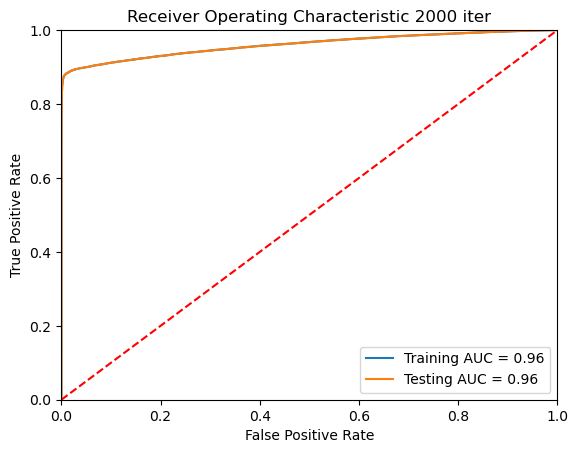

In [15]:
draw_image(ann, X_train, X_test, y_train, y_test)